# Batch Bayesian Optimization

Sometimes it is practically convenient to query several points at a time. We can do this in `trieste` using a `BatchAcquisitionRule` and a `BatchAcquisitionFunctionBuilder`, that together recommend a number of query points `num_query_points` (instead of one as previously). The optimizer then queries the observer at all these points simultaneously.
Here we use the `BatchMonteCarloExpectedImprovement` function. Note that this acquisition function is computed using a Monte-Carlo method (so it requires a `sample_size`), but with a reparametrisation trick, which makes it deterministic.

In [1]:
import numpy as np
import tensorflow as tf
import trieste 

np.random.seed(1234)
tf.random.set_seed(1234)

## Describe the problem

In [2]:
from trieste.utils.objectives import mk_observer
from trieste.acquisition.rule import OBJECTIVE
from trieste.utils.objectives import branin
from trieste.space import Box
from util.plotting_plotly import plot_function_plotly
from util.plotting import create_grid, plot_acq_function_2d


observer = mk_observer(branin, OBJECTIVE)
search_space = Box([0, 0], [1, 1])

num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

In [3]:
import gpflow
from trieste.models import  create_model
from trieste.utils import map_values

def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2, 0.2])
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    model_spec =  {
        "model": gpr,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    }
    
    return {OBJECTIVE: {
        "model": gpr,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    }}


model_spec = build_model(initial_data[OBJECTIVE])
models = map_values(create_model, model_spec)

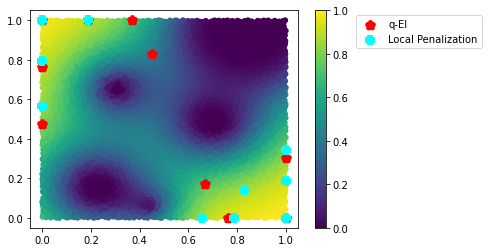

In [4]:
from trieste.acquisition import ExpectedImprovement, BatchMonteCarloExpectedImprovement, LocallyPenalizedExpectedImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


x = tf.expand_dims(tfp.mcmc.sample_halton_sequence(2,10000,dtype=tf.float64),1)
ei = ExpectedImprovement()
ei_acq_function = ei.using(OBJECTIVE).prepare_acquisition_function(initial_data, models)
evals = ei_acq_function(x)
plt.scatter(x[:,:,0],x[:,:,1],lw=0.0001,c=evals,cmap="viridis")



qei = BatchMonteCarloExpectedImprovement(sample_size=1000)
chosen_points, _ = EfficientGlobalOptimization(num_query_points=10, builder=qei.using(OBJECTIVE)).acquire(search_space, initial_data, models)
plt.scatter(chosen_points[:,0],chosen_points[:,1],color="red",lw=5, label="q-EI",marker="*")

soft_local_penalization = LocallyPenalizedExpectedImprovement(search_space, num_samples=1000)
chosen_points, _ = EfficientGlobalOptimization(num_query_points=10, builder=soft_local_penalization.using(OBJECTIVE)).acquire(search_space, initial_data, models)
plt.scatter(chosen_points[:,0],chosen_points[:,1],color="cyan",lw=10,label="Local Penalization",marker="+")

plt.colorbar()
plt.legend(bbox_to_anchor=(1.2,1), loc="upper left")



In [5]:
plot_acq_function_2d(ei.using(OBJECTIVE).prepare_acquisition_function(initial_data, models),
   [0,0],
    [1,1])

ValueError: Attempt to convert a value (<function expected_improvement.<locals>.acquisition at 0x7f347031acb0>) with an unsupported type (<class 'function'>) to a Tensor.

In [ ]:
from trieste.acquisition.rule import EfficientGlobalOptimization

qei = trieste.acquisition.BatchMonteCarloExpectedImprovement(sample_size=1000)
batch_rule: EfficientGlobalOptimization[Box] = EfficientGlobalOptimization(
    num_query_points=3, builder=qei.using(OBJECTIVE)
)



bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
batch_result = bo.optimize(5, initial_data, model, acquisition_rule=batch_rule)